In [3]:
# %pip install requests pandas python-dateutil -q

import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
from dateutil import parser as dtp

USER_AGENT = "michal-weather-analysis/1.0 (michal.jemelka@gmail.com)"

def _extract_precip_mm(entry: dict) -> float:
    data = entry.get("data", {})
    for key in ("next_1_hours", "next_6_hours", "next_12_hours"):
        block = data.get(key)
        if block and "details" in block and "precipitation_amount" in block["details"]:
            return float(block["details"]["precipitation_amount"])
    return 0.0

def _extract_temp_c(entry: dict) -> float | None:
    try:
        return float(entry["data"]["instant"]["details"]["air_temperature"])
    except Exception:
        return None

def _extract_cloud_frac(entry: dict) -> float | None:
    try:
        return float(entry["data"]["instant"]["details"]["cloud_area_fraction"])
    except Exception:
        return None

def _extract_wind_speed(entry: dict) -> float | None:
    try:
        return float(entry["data"]["instant"]["details"]["wind_speed"])
    except Exception:
        return None

def _extract_wind_gust(entry: dict) -> float | None:
    # V JSONu se často jmenuje "wind_speed_of_gust"
    try:
        return float(entry["data"]["instant"]["details"]["wind_speed_of_gust"])
    except Exception:
        return None

def get_forecast_yr_week(lat: float, lon: float) -> pd.DataFrame:
    """
    Vrátí denní souhrny na 7 dní (ode dneška včetně):
    - min/max teplota (°C), suma srážek (mm), průměrná oblačnost (%),
      max. rychlost větru (m/s) a max. poryv (m/s).
    """
    url = "https://api.met.no/weatherapi/locationforecast/2.0/compact"
    headers = {"User-Agent": USER_AGENT}
    params = {"lat": round(lat, 4), "lon": round(lon, 4)}
    r = requests.get(url, params=params, headers=headers, timeout=20)
    r.raise_for_status()

    ts = r.json()["properties"]["timeseries"]
    rows = []
    for item in ts:
        t_utc = dtp.isoparse(item["time"])
        rows.append({
            "time_utc": t_utc,
            "temp_c": _extract_temp_c(item),
            "precip_mm": _extract_precip_mm(item),
            "cloud_pct": _extract_cloud_frac(item),
            "wind_mps": _extract_wind_speed(item),
            "gust_mps": _extract_wind_gust(item),
        })

    df = pd.DataFrame(rows)

    # Omezíme na 7 dní od teď (UTC)
    now_utc = datetime.now(timezone.utc)
    end_utc = now_utc + timedelta(days=7)
    df = df[(df["time_utc"] >= now_utc) & (df["time_utc"] < end_utc)].copy()

    # Lokální den (Europe/Prague)
    df["time_utc"] = pd.to_datetime(df["time_utc"], utc=True)
    try:
        df["time_prg"] = df["time_utc"].dt.tz_convert("Europe/Prague")
    except Exception:
        df["time_prg"] = df["time_utc"]
    df["date"] = df["time_prg"].dt.date

    agg = (
        df.groupby("date")
          .agg(min_temp_c=("temp_c", "min"),
               max_temp_c=("temp_c", "max"),
               precip_mm=("precip_mm", "sum"),
               cloud_pct=("cloud_pct", "mean"),
               max_wind_mps=("wind_mps", "max"),
               max_gust_mps=("gust_mps", "max"))
          .reset_index()
          .sort_values("date")
    )

    for col in ("min_temp_c", "max_temp_c", "precip_mm", "cloud_pct", "max_wind_mps", "max_gust_mps"):
        agg[col] = agg[col].round(1)

    agg.insert(0, "location", "Bedřichov (Jablonec n. N.)")
    return agg

def export_forecast_to_csv(df: pd.DataFrame, filename: str | None = None) -> str:
    if filename is None:
        ts = datetime.now().strftime("%Y%m%d_%H%M")
        filename = f"forecast_bedrichov_{ts}.csv"
    df.to_csv(filename, index=False, encoding="utf-8-sig")
    return filename


In [4]:
LAT, LON = 50.7911, 15.1425
forecast_week = get_forecast_yr_week(LAT, LON)
forecast_week


,location,date,min_temp_c,max_temp_c,precip_mm,cloud_pct,max_wind_mps,max_gust_mps
0,Bedřichov (Jablonec n. N.),2025-10-06,6.6,6.6,0.0,100.0,3.8,NaN
1,Bedřichov (Jablonec n. N.),2025-10-07,6.3,10.0,0.9,88.0,5.4,NaN
2,Bedřichov (Jablonec n. N.),2025-10-08,7.2,10.4,4.6,100.0,3.0,NaN
3,Bedřichov (Jablonec n. N.),2025-10-09,8.8,10.1,3.0,99.8,4.3,NaN
4,Bedřichov (Jablonec n. N.),2025-10-10,7.0,10.1,2.6,88.7,5.6,NaN
5,Bedřichov (Jablonec n. N.),2025-10-11,6.6,8.7,5.2,86.9,5.8,NaN
6,Bedřichov (Jablonec n. N.),2025-10-12,6.7,8.5,2.7,99.6,4.8,NaN
7,Bedřichov (Jablonec n. N.),2025-10-13,5.7,8.5,3.7,95.3,2.2,NaN


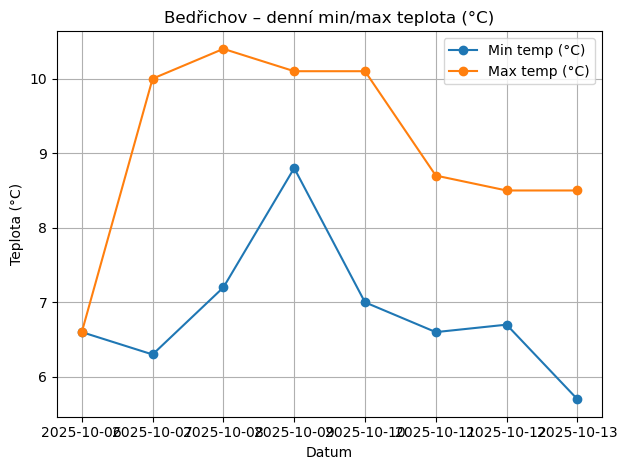

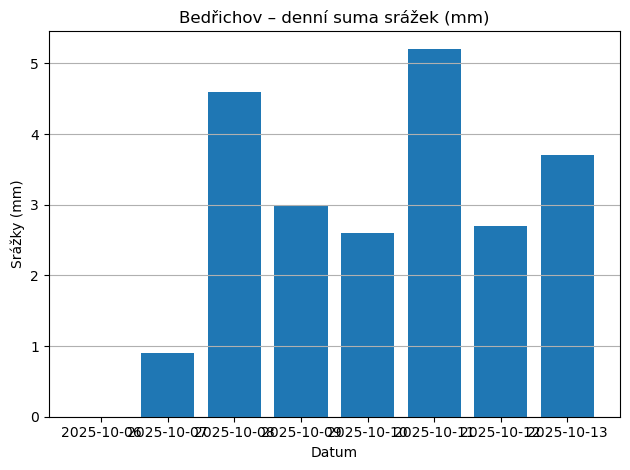

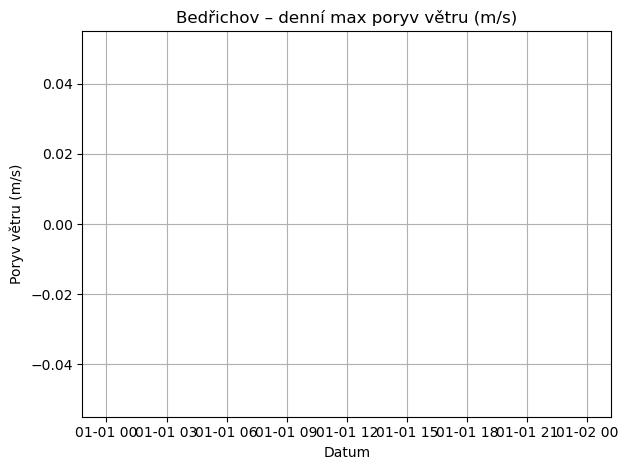

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Připravíme si osu X jako datetime
x = pd.to_datetime(forecast_week["date"])

# 1) Min/Max teplota
plt.figure()
plt.plot(x, forecast_week["min_temp_c"], marker="o", label="Min temp (°C)")
plt.plot(x, forecast_week["max_temp_c"], marker="o", label="Max temp (°C)")
plt.title("Bedřichov – denní min/max teplota (°C)")
plt.xlabel("Datum")
plt.ylabel("Teplota (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Suma srážek
plt.figure()
plt.bar(x, forecast_week["precip_mm"])
plt.title("Bedřichov – denní suma srážek (mm)")
plt.xlabel("Datum")
plt.ylabel("Srážky (mm)")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# 3) Max poryv větru
plt.figure()
plt.plot(x, forecast_week["max_gust_mps"], marker="o")
plt.title("Bedřichov – denní max poryv větru (m/s)")
plt.xlabel("Datum")
plt.ylabel("Poryv větru (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()
